In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your directories and parameters
train_dir = "/kaggle/input/custom-dataset/ai_images_vs_real_image/train"
test_dir = "/kaggle/input/custom-dataset/ai_images_vs_real_image/test"
batch_size = 64
image_height = 224
image_width = 224

# Define transforms
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
])

# Load your dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define your CNN model in PyTorch
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Adjust the view size based on your image dimensions
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of your CNN model and move it to GPU manually
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train your model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU manually
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

# Save the trained PyTorch model
torch.save(model.state_dict(), "/kaggle/working/trained_model.pth")


Using device: cuda


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 20.26756852865219
Epoch 2, Loss: 9.516034126281738
Epoch 3, Loss: 9.299113810062408
Epoch 4, Loss: 9.075087070465088
Epoch 5, Loss: 8.631232857704163
Epoch 6, Loss: 8.667898833751678
Epoch 7, Loss: 7.922992050647736
Epoch 8, Loss: 7.336927711963654
Epoch 9, Loss: 6.645132809877396
Epoch 10, Loss: 5.843180686235428


In [2]:
# Load the saved PyTorch model for inference
loaded_model = CustomCNN(num_classes)
loaded_model.load_state_dict(torch.load("/kaggle/working/trained_model.pth"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Predicted Class: 0
Probabilities: [[0.61366206 0.3863379 ]]


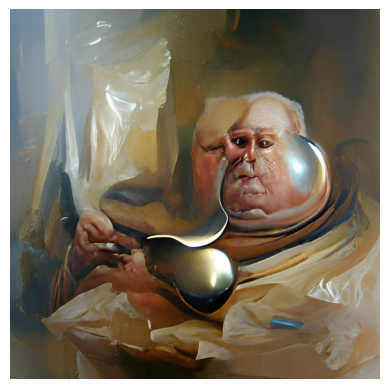

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
# Perform inference on the image
image_path = "/kaggle/input/custom-dataset/ai_images_vs_real_image/test/AiArtData/07-the-coffee-service-hossaini-art-ai.x3e656121.png"
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
])
img_tensor = preprocess(image).unsqueeze(0).to(device)

# Forward pass through the loaded PyTorch model
with torch.no_grad():
    outputs = model(img_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()  # Move back to CPU for numpy
    predicted_class = np.argmax(probabilities)

# Print the predicted class and probabilities
print("Predicted Class:", predicted_class)
print("Probabilities:", probabilities)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()